# Lab 3

In [77]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

np.random.seed(82)

# Display settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# Task 5.1: Data Pre-processing

In [78]:
# Load the training data
df = pd.read_csv('/kaggle/input/train-users-csv/train_users.csv')
print(f"Dataset shape: {df.shape}")
print(f"Number of users: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

Dataset shape: (2000, 33)
Number of users: 2000
Number of features: 33


In [79]:
df.head()

,user_id,age,income,clicks,purchase_amount,session_duration,content_variety,engagement_score,num_transactions,avg_monthly_spend,avg_cart_value,browsing_depth,revisit_rate,scroll_activity,time_on_site,interaction_count,preferred_price_range,discount_usage_rate,wishlist_size,product_views,repeat_purchase_gap (days),churn_risk_score,loyalty_index,screen_brightness,battery_percentage,cart_abandonment_count,browser_version,background_app_count,session_inactivity_duration,network_jitter,region_code,subscriber,label
0,U7392,NaN,23053,10,500.00,17.34,0.36661,37.29781,3,187.44,119.61,13,0.255,59,19.0,18,335.16,0.341,3,41,133.0,0.579825,15.0,4.0,2.0,8,3.17.97,10,22.75,8.0,Z999,False,user_3
1,U2702,56.0,20239,11,913.33,22.22,0.61370,59.36342,5,145.15,189.06,14,0.540,65,31.0,8,930.00,0.374,4,70,92.0,0.432731,33.0,4.5,63.0,5,1.57.10,8,1.75,4.0,U428,True,user_2
2,U2461,NaN,13907,9,1252.62,41.57,0.80368,76.78706,7,282.03,161.75,23,0.395,139,44.0,20,1216.41,0.274,5,45,67.0,0.308166,24.0,1.3,22.0,2,2.16.94,12,29.33,18.0,Z999,True,user_3
3,U7475,NaN,26615,12,500.00,30.17,0.26499,30.19441,10,195.35,23.91,15,0.204,99,35.0,16,398.62,0.252,6,62,149.0,0.708171,11.0,4.2,77.0,9,9.90.20,4,21.61,22.0,X123,False,user_3
4,U6040,32.0,27958,13,500.00,65.27,0.36385,37.12153,5,439.68,57.68,39,0.313,180,62.0,30,462.73,0.267,0,67,117.0,0.595416,19.0,4.6,30.0,9,1.99.38,7,7.58,52.0,S043,False,user_1


In [80]:
# Check for missing values
print("Missing Values Summary:")
missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Missing Count': df.isnull().sum().values,
    'Missing Percentage': (df.isnull().sum().values / len(df) * 100).round(2)
})
missing_summary = missing_summary[missing_summary['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
print(missing_summary)

Missing Values Summary:
  Column  Missing Count  Missing Percentage
1    age            698                34.9


In [81]:
# Check label distribution
print("\nLabel Distribution:")
label_counts = df['label'].value_counts()
print(label_counts)
print(f"\nPercentage distribution:")
print((label_counts / len(df) * 100).round(2))


Label Distribution:
label
user_2    712
user_1    707
user_3    581
Name: count, dtype: int64

Percentage distribution:
label
user_2    35.60
user_1    35.35
user_3    29.05
Name: count, dtype: float64


In [82]:
# Identify column types
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()

# Remove target and ID from feature lists
if 'label' in numerical_cols:
    numerical_cols.remove('label')
if 'label' in categorical_cols:
    categorical_cols.remove('label')
if 'user_id' in categorical_cols:
    categorical_cols.remove('user_id')

print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")

Numerical columns (28): ['age', 'income', 'clicks', 'purchase_amount', 'session_duration', 'content_variety', 'engagement_score', 'num_transactions', 'avg_monthly_spend', 'avg_cart_value', 'browsing_depth', 'revisit_rate', 'scroll_activity', 'time_on_site', 'interaction_count', 'preferred_price_range', 'discount_usage_rate', 'wishlist_size', 'product_views', 'repeat_purchase_gap (days)', 'churn_risk_score', 'loyalty_index', 'screen_brightness', 'battery_percentage', 'cart_abandonment_count', 'background_app_count', 'session_inactivity_duration', 'network_jitter']

Categorical columns (3): ['browser_version', 'region_code', 'subscriber']


In [83]:
# Create a copy for preprocessing
df_processed = df.copy()

# Remove user_id column as it's not a feature
df_processed = df_processed.drop('user_id', axis=1)

print("Dropped 'user_id' column")
print(f"New shape: {df_processed.shape}")

Dropped 'user_id' column
New shape: (2000, 32)


In [84]:
# Handle missing values in numerical columns
# Using median imputation for numerical features
numerical_imputer = SimpleImputer(strategy='median')

# Get numerical columns (excluding label)
num_cols_to_impute = [col for col in numerical_cols if col in df_processed.columns]

if num_cols_to_impute:
    df_processed[num_cols_to_impute] = numerical_imputer.fit_transform(df_processed[num_cols_to_impute])
    print(f"Imputed missing values in {len(num_cols_to_impute)} numerical columns using median strategy")

# Verify no missing values remain
print(f"\nRemaining missing values: {df_processed.isnull().sum().sum()}")

Imputed missing values in 28 numerical columns using median strategy

Remaining missing values: 0


In [85]:
# Encode categorical features
label_encoders = {}

# Encode categorical columns (excluding the target 'label')
cat_cols_to_encode = [col for col in categorical_cols if col in df_processed.columns and col != 'label']

for col in cat_cols_to_encode:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le
    print(f"Encoded column: {col} ({df_processed[col].nunique()} unique values)")

print(f"\nTotal categorical columns encoded: {len(cat_cols_to_encode)}")

Encoded column: browser_version (1973 unique values)
Encoded column: region_code (1284 unique values)
Encoded column: subscriber (2 unique values)

Total categorical columns encoded: 3


In [87]:
# Encode target variable (label)
target_encoder = LabelEncoder()
df_processed['label_encoded'] = target_encoder.fit_transform(df_processed['label'])

print("Target variable encoding:")
for i, class_name in enumerate(target_encoder.classes_):
    print(f"  {class_name} -> {i}")

Target variable encoding:
  user_1 -> 0
  user_2 -> 1
  user_3 -> 2


In [88]:
# Separate features and target
X = df_processed.drop(['label', 'label_encoded'], axis=1)
y = df_processed['label_encoded']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns ({X.shape[1]}): {list(X.columns)}")

Features shape: (2000, 31)
Target shape: (2000,)

Feature columns (31): ['age', 'income', 'clicks', 'purchase_amount', 'session_duration', 'content_variety', 'engagement_score', 'num_transactions', 'avg_monthly_spend', 'avg_cart_value', 'browsing_depth', 'revisit_rate', 'scroll_activity', 'time_on_site', 'interaction_count', 'preferred_price_range', 'discount_usage_rate', 'wishlist_size', 'product_views', 'repeat_purchase_gap (days)', 'churn_risk_score', 'loyalty_index', 'screen_brightness', 'battery_percentage', 'cart_abandonment_count', 'browser_version', 'background_app_count', 'session_inactivity_duration', 'network_jitter', 'region_code', 'subscriber']


In [89]:
# Display summary statistics
print("Summary Statistics of Features:")
X.describe()

Summary Statistics of Features:


,age,income,clicks,purchase_amount,session_duration,content_variety,engagement_score,num_transactions,avg_monthly_spend,avg_cart_value,browsing_depth,revisit_rate,scroll_activity,time_on_site,interaction_count,preferred_price_range,discount_usage_rate,wishlist_size,product_views,repeat_purchase_gap (days),churn_risk_score,loyalty_index,screen_brightness,battery_percentage,cart_abandonment_count,browser_version,background_app_count,session_inactivity_duration,network_jitter,region_code,subscriber
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,39.148000,21564.393500,10.526000,854.920700,32.641035,0.491309,49.325532,6.019000,359.416645,172.206590,19.565500,0.351361,98.116500,32.936000,14.486000,855.162015,0.300158,3.003500,52.151000,105.842000,0.506943,21.145000,3.057850,51.219000,5.05300,988.705000,9.456500,15.091855,24.514500,824.706000,0.278000
std,9.203176,6740.282694,3.299207,833.770472,22.769625,0.244320,24.584840,2.561429,413.886399,189.172863,12.778198,0.141125,69.124381,23.858091,8.566884,841.260803,0.121174,2.680313,19.834059,37.053482,0.246216,9.541934,1.102046,27.704671,2.28797,569.503186,3.457034,8.547876,18.501836,395.264335,0.448125
min,18.000000,10000.000000,1.000000,500.000000,0.000000,0.005040,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,109.320000,0.033000,0.000000,0.000000,17.000000,0.000000,0.000000,1.200000,2.000000,0.00000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,16742.500000,8.000000,500.000000,10.987500,0.289365,31.912582,4.000000,150.147500,67.840000,8.000000,0.251000,35.000000,12.000000,8.000000,460.177500,0.221750,1.000000,39.000000,83.000000,0.351813,15.000000,2.100000,28.000000,3.00000,496.750000,6.000000,7.657500,10.000000,487.750000,0.000000
50%,39.000000,21107.500000,10.000000,500.000000,33.475000,0.493505,49.566750,6.000000,231.370000,106.145000,20.000000,0.348000,98.000000,31.000000,14.000000,539.750000,0.279000,3.000000,52.000000,106.000000,0.507508,20.000000,3.100000,52.000000,5.00000,989.500000,9.000000,15.420000,21.000000,974.500000,0.000000
75%,42.000000,25892.500000,13.000000,596.295000,48.732500,0.661632,64.603265,8.000000,393.437500,184.415000,29.000000,0.440000,146.000000,51.000000,21.000000,691.692500,0.355000,5.000000,65.000000,133.000000,0.679260,26.000000,4.000000,74.000000,6.00000,1481.250000,12.000000,22.295000,35.000000,1151.000000,1.000000
max,70.000000,51776.000000,25.000000,4873.670000,89.960000,0.993540,100.000000,19.000000,4555.030000,1000.000000,50.000000,0.812000,280.000000,99.000000,42.000000,4927.900000,0.789000,15.000000,116.000000,180.000000,1.000000,77.000000,5.000000,100.000000,14.00000,1972.000000,15.000000,29.980000,95.000000,1283.000000,1.000000


# Task 5.2: User Classification

In [90]:
# Split the data: 80% training, 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain class distribution
)

print(f"\nTraining set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set size: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")

# Verify stratification
print("\nClass distribution in training set:")
print(pd.Series(y_train).value_counts().sort_index())
print("\nClass distribution in validation set:")
print(pd.Series(y_val).value_counts().sort_index())


Training set size: 1600 samples (80.0%)
Validation set size: 400 samples (20.0%)

Class distribution in training set:
label_encoded
0    565
1    570
2    465
Name: count, dtype: int64

Class distribution in validation set:
label_encoded
0    142
1    142
2    116
Name: count, dtype: int64


In [91]:
# Scale features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Validation set shape: {X_val_scaled.shape}")

Training set shape: (1600, 31)
Validation set shape: (400, 31)


In [92]:
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        random_state=42,
        multi_class='multinomial',
        solver='lbfgs'
    )
}

print("Models initialized:")
for name in models.keys():
    print(f"  - {name}")

Models initialized:
  - Random Forest
  - Decision Tree
  - Logistic Regression


In [93]:
# Train and evaluate all models
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    # Use scaled data for Logistic Regression, original for tree-based models
    if name == 'Logistic Regression':
        X_train_use = X_train_scaled
        X_val_use = X_val_scaled
    else:
        X_train_use = X_train
        X_val_use = X_val
    
    # Train the model
    model.fit(X_train_use, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train_use)
    y_val_pred = model.predict(X_val_use)
    
    # Calculate accuracies
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    
    # Store results
    results[name] = {
        'model': model,
        'train_accuracy': train_acc,
        'val_accuracy': val_acc,
        'predictions': y_val_pred
    }
    
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Difference: {abs(train_acc - val_acc):.4f}")

Training Random Forest...
Training Accuracy: 0.9744
Validation Accuracy: 0.9000
Difference: 0.0744
Training Decision Tree...
Training Accuracy: 0.9225
Validation Accuracy: 0.8650
Difference: 0.0575
Training Logistic Regression...
Training Accuracy: 0.8381
Validation Accuracy: 0.8200
Difference: 0.0181


In [94]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Training Accuracy': [results[m]['train_accuracy'] for m in results.keys()],
    'Validation Accuracy': [results[m]['val_accuracy'] for m in results.keys()],
    'Overfitting': [abs(results[m]['train_accuracy'] - results[m]['val_accuracy']) for m in results.keys()]
})

comparison_df = comparison_df.sort_values('Validation Accuracy', ascending=False)
print("\nModel Comparison:")
print(comparison_df.to_string(index=False))


Model Comparison:
              Model  Training Accuracy  Validation Accuracy  Overfitting
      Random Forest           0.974375                0.900     0.074375
      Decision Tree           0.922500                0.865     0.057500
Logistic Regression           0.838125                0.820     0.018125


In [95]:
# Select best model based on validation accuracy
best_model_name = max(results.items(), key=lambda x: x[1]['val_accuracy'])[0]
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']

print(f"Best Model: {best_model_name}")
print(f"Validation Accuracy: {results[best_model_name]['val_accuracy']:.4f}")

Best Model: Random Forest
Validation Accuracy: 0.9000


In [96]:
# Classification Report
print(f"CLASSIFICATION REPORT - {best_model_name}")
print(classification_report(y_val, best_predictions, 
                          target_names=target_encoder.classes_,
                          digits=4))

CLASSIFICATION REPORT - Random Forest
              precision    recall  f1-score   support

      user_1     0.8971    0.8592    0.8777       142
      user_2     0.9766    0.8803    0.9259       142
      user_3     0.8309    0.9741    0.8968       116

    accuracy                         0.9000       400
   macro avg     0.9015    0.9045    0.9001       400
weighted avg     0.9061    0.9000    0.9004       400



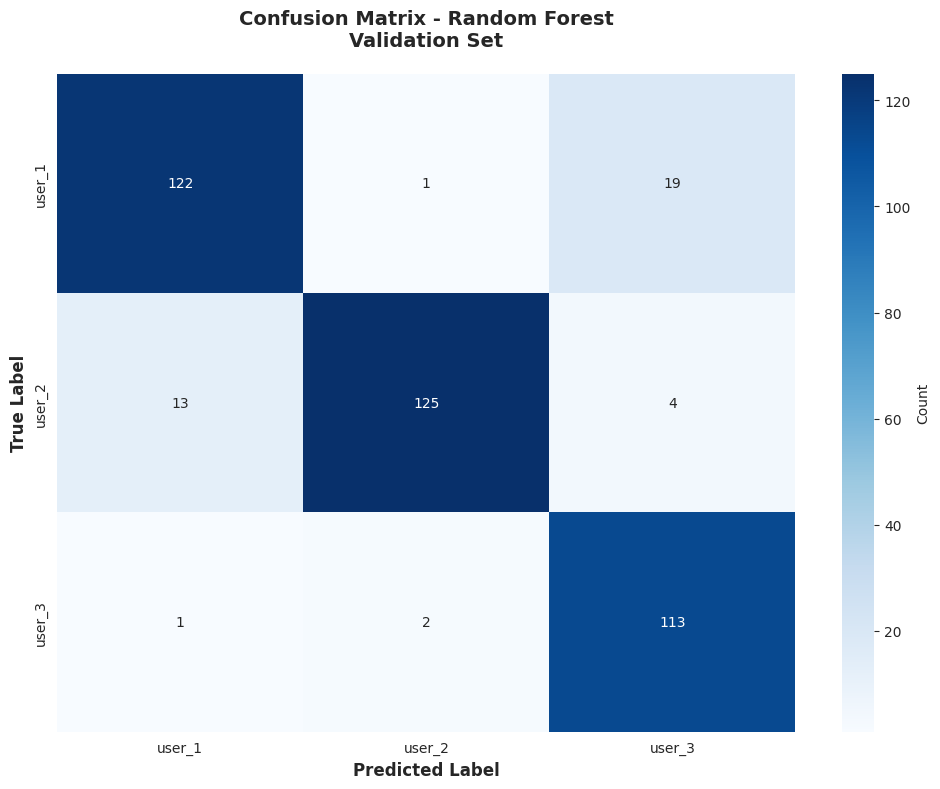


Per-Class Accuracy:
  user_1: 0.8592
  user_2: 0.8803
  user_3: 0.9741


In [97]:
# Confusion Matrix
cm = confusion_matrix(y_val, best_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}\nValidation Set', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate per-class accuracy from confusion matrix
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(target_encoder.classes_):
    class_acc = cm[i, i] / cm[i, :].sum()
    print(f"  {class_name}: {class_acc:.4f}")